In [2]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playbyplay,leaguegamefinder,leaguedashteamstats
from nba_api.stats.static import teams
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep
from tqdm.notebook import tqdm
pd.options.display.max_columns = None
from scipy import stats
from fitter import Fitter
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import flexcode
from flexcode.regression_models import XGBoost
from xgboost import XGBRegressor
import optuna


In [3]:
all_runs_to = pd.concat([pd.read_pickle('C:/Users/isaac/Desktop/Proyectos/nba_analysis/timeout_analysis/preprocessing/data/all_runs_to_2015-2018.pkl'),
                         pd.read_pickle('C:/Users/isaac/Desktop/Proyectos/nba_analysis/timeout_analysis/preprocessing/data/all_runs_to_2019-2023.pkl')])

In [79]:
all_runs_to['net_diff_home'] = (all_runs_to['home_score'] - all_runs_to['previous_run_home_score']) - (all_runs_to['away_score'] - all_runs_to['previous_run_away_score'])
all_runs_to['net_diff_away'] = (all_runs_to['away_score'] - all_runs_to['previous_run_away_score']) - (all_runs_to['home_score'] - all_runs_to['previous_run_home_score'])

In [80]:
all_runs_to['gp'] = all_runs_to['gp'].astype(str)

In [81]:
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('4')==False]
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('5')==False]
all_runs_to.reset_index(drop=True,inplace=True)

In [82]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] + 10

In [83]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] + 10

In [84]:
all_runs_to['scoring_ratio'] = (((all_runs_to['home_score']-all_runs_to['previous_run_home_score']) -(all_runs_to['away_score']-all_runs_to['previous_run_away_score'])) /all_runs_to['time_spent_run']).fillna(0)

In [76]:
# def toggle_team(current_team, home_team, away_team):
#     return home_team if current_team == away_team else away_team

# all_runs_to['run_team'] = all_runs_to.apply(
#     lambda row: toggle_team(row['run_team'], row['home_team'], row['away_team']) 
#     if row['run_team'] == row['next_run_team'] else row['run_team'], axis=1
# )

In [89]:
all_runs_to['Season'] = all_runs_to['gp'].str[3:5].astype(int)

In [90]:
# Loop through window sizes from 2 to 5 for backward-looking averages
for i in range(2, 6):
    all_runs_to[f'avg_{i}_scoring_ratio'] = (
        all_runs_to.groupby('gp')['scoring_ratio']
        .rolling(window=i, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Create shifted columns for forward-looking sums
for shift in range(1, 6):
    all_runs_to[f'shift_-{shift}_scoring_ratio'] = all_runs_to.groupby('gp')['scoring_ratio'].shift(-shift)

# Calculate the forward-looking averages for the next 1 to 5 runs
for i in range(1, 6):
    # Forward-looking average for 'scoring_ratio'
    all_runs_to[f'next_{i}_avg_scoring_ratio'] = (
        sum(all_runs_to[f'shift_-{shift}_scoring_ratio'] for shift in range(1, i+1)) / i
    ).fillna(method='ffill')

# Drop the intermediate shifted columns if no longer needed
all_runs_to.drop(columns=[f'shift_-{shift}_scoring_ratio' for shift in range(1, 6)], inplace=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\4017142516.py:19: FutureWarning: Serie

In [91]:
all_runs_to['run_length_continued'] = all_runs_to['run_length'] - (all_runs_to['to_index'] + 1)

In [92]:
df_analysis = all_runs_to.copy()

In [93]:
model_cols = [x for x in df_analysis.columns if 'next' not in x and 'scoring_ratio' in x]
model_cols_2 = ['avg_opponent_run_length', 'opponent_run_length_max',
       'opponent_run_length_min', 'avg_own_run_length', 'own_run_length_max',
       'own_run_length_min', 'net_diff_home','net_diff_away','next_3_avg_scoring_ratio','previous_run_time', 'last_run_time', 'time_spent_run', 'to_time','Season']
model_cols = model_cols + model_cols_2

In [94]:
to_df = df_analysis[(df_analysis['to_non_run']==1)][model_cols]

In [15]:
X = to_df.drop(['next_3_avg_scoring_ratio','Season'],axis=1)

In [16]:
X.fillna(0,inplace=True)

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)

In [18]:
pca_components_df = pd.DataFrame(pca_components,columns=['PC1','PC2','PC3'])
pca_components_df['home_to'] = df_analysis[(df_analysis['to_non_run']==1)]['home_to'].values

In [19]:
pca_components_df['next_3_avg_scoring_ratio'] = df_analysis[(df_analysis['to_non_run']==1)]['next_3_avg_scoring_ratio'].values
pca_components_df['Season'] = (df_analysis[(df_analysis['to_non_run']==1)]['Season'].values).astype(int)

In [20]:
train_df = pca_components_df[pca_components_df['Season']<23]
test_df = pca_components_df[pca_components_df['Season']==23]

In [21]:
assert len(df_analysis[(df_analysis['to_non_run']==1)]) == len(train_df) + len(test_df)

In [22]:
X_train = train_df.drop(['Season','next_3_avg_scoring_ratio'],axis=1)
y_train = train_df['next_3_avg_scoring_ratio']
X_test = test_df.drop(['Season','next_3_avg_scoring_ratio'],axis=1)
y_test = test_df['next_3_avg_scoring_ratio']

In [23]:
# # Define the objective function
# def objective(trial):
#     # Suggest hyperparameters
#     max_basis = trial.suggest_int('max_basis', 30, 70)
#     basis_system = trial.suggest_categorical('basis_system', ['cosine'])
    
#     n_estimators = trial.suggest_int('n_estimators', 10, 1500)
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1,log=True)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
    
#     # Parameterize the model with the suggested hyperparameters
#     model = flexcode.FlexCodeModel(
#         XGBoost,
#         max_basis=max_basis,
#         basis_system=basis_system,
#         regression_params={
#             'n_estimators': n_estimators,
#             'learning_rate': learning_rate,
#             'max_depth': max_depth
#         }
#     )
    
#     # Fit the model
#     model.fit(X_train.values, y_train.values)
    
#     # Evaluate the model
#     cde_loss = np.abs(model.estimate_error(X_test.values, y_test.values, n_grid=1000))
    
#     return cde_loss

# # Create the Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)

# # Train the final model with the best hyperparameters
# best_params = study.best_params
# final_model = flexcode.FlexCodeModel(
#     XGBoost,
#     max_basis=best_params['max_basis'],
#     basis_system=best_params['basis_system'],
#     regression_params={
#         'n_estimators': best_params['n_estimators'],
#         'learning_rate': best_params['learning_rate'],
#         'max_depth': best_params['max_depth']
#     }
# )
# final_model.fit(X_train.values, y_train.values)

# # Evaluate the final model
# final_cde_loss = final_model.estimate_error(X_test.values, y_test.values, n_grid=1000)
# print("Final Model CDE Loss: ", final_cde_loss)

In [24]:
#{'max_basis': 68, 'basis_system': 'cosine', 'n_estimators': 499, 'learning_rate': 0.09978082774194517, 'max_depth': 10}
#{'max_basis': 64, 'basis_system': 'cosine', 'n_estimators': 1149, 'learning_rate': 0.06162001801080429, 'max_depth': 9}
#'n_estimators': 1309, 'learning_rate': 0.09865765655385056, 'max_depth': 8}

Average Log-Likelihood: -4.223478510346469
RMSE for Conditional Mean: 0.08966331677159187
RMSE for Conditional Standard Deviation: 0.19221321510901432


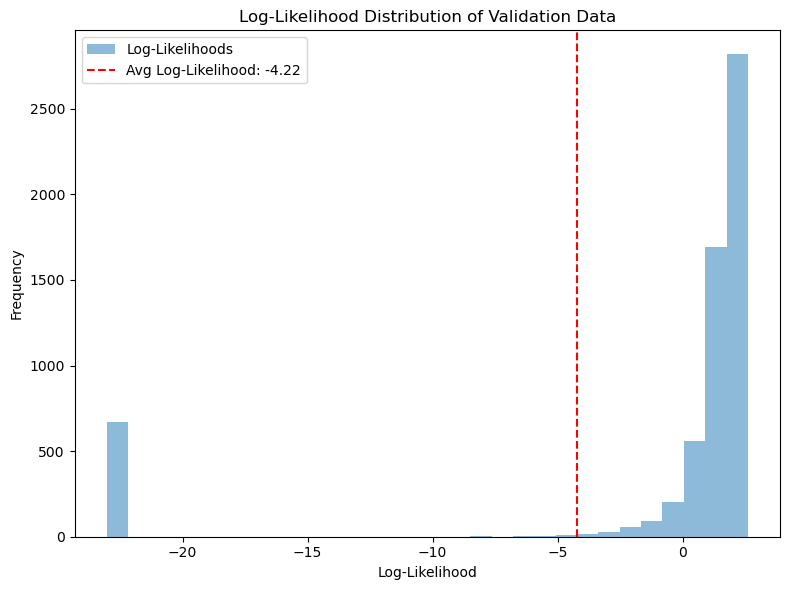

In [25]:
# Parameterize and fit the FlexCode model
model = flexcode.FlexCodeModel(XGBoost, max_basis=64, basis_system="cosine",
                               regression_params={'n_estimators': 1470, 'learning_rate': 0.0808881770364235, 'max_depth': 10})
model.fit(X_train.values, y_train.values)

#Predict conditional densities and y grid using the model for validation set
cdes, y_grid_flexcode = model.predict(X_test.values, n_grid=1000)
y_grid_flexcode = y_grid_flexcode.reshape(-1)

# Define function to calculate the expectation (mean) and standard deviation of the estimated distribution
def conditional_mean_std(cde, y_grid):
    mean_est = np.sum(y_grid * cde) / np.sum(cde)  # Mean as the weighted average
    std_est = np.sqrt(np.sum(((y_grid - mean_est) ** 2) * cde) / np.sum(cde))  # Std deviation
    return mean_est, std_est

# Calculate metrics
log_likelihoods = []
rmse_means = []
rmse_stds = []

epsilon = 1e-10  # Small value to avoid log(0)

# Iterate over validation set
for i in range(len(X_test)):
    y_value = y_test.values[i]
    cde = cdes[i]

    # Calculate conditional mean and standard deviation for the estimated distribution
    mean_est, std_est = conditional_mean_std(cde, y_grid_flexcode)

    # Calculate log-likelihood with epsilon to avoid log(0)
    interpolated_density = np.interp(y_value, y_grid_flexcode, cde, left=0, right=0) + epsilon
    log_likelihood = np.log(interpolated_density)
    log_likelihoods.append(log_likelihood)

    # Calculate RMSE for mean
    rmse_mean = (y_value - mean_est) ** 2
    rmse_means.append(rmse_mean)

    # Calculate RMSE for standard deviation
    rmse_std = ((abs(y_value - mean_est) - std_est) ** 2)
    rmse_stds.append(rmse_std)

# Average log-likelihood
avg_log_likelihood = model.estimate_error(X_test.values, y_test.values)

# RMSE for mean
rmse_mean = np.sqrt(np.mean(rmse_means))

# RMSE for standard deviation
rmse_std = np.sqrt(np.mean(rmse_stds))

print("Average Log-Likelihood:", avg_log_likelihood)
print("RMSE for Conditional Mean:", rmse_mean)
print("RMSE for Conditional Standard Deviation:", rmse_std)

# Plotting the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(log_likelihoods, bins=30, alpha=0.5, label='Log-Likelihoods')
ax.axvline(avg_log_likelihood, color='r', linestyle='--', label=f'Avg Log-Likelihood: {avg_log_likelihood:.2f}')
ax.set_title("Log-Likelihood Distribution of Validation Data")
ax.set_xlabel("Log-Likelihood")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()
# Average Log-Likelihood: -0.32862157953660187
# RMSE for Conditional Mean: 0.05549503556260016
# RMSE for Conditional Standard Deviation: 0.09122680736668978

c:\Users\isaac\.conda\envs\timeout_analysis\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
crystalball,5.458627,1472.131128,1498.117457,inf,0.019256,0.052220
norm,7.372443,3294.858458,3307.851622,inf,0.031258,0.000136
pearson3,7.377283,3124.683794,3144.173540,inf,0.031615,0.000109
lognorm,7.378784,3329.503320,3348.993067,inf,0.031485,0.000119
t,9.231891,1013.272280,1032.762026,inf,0.026162,0.002406


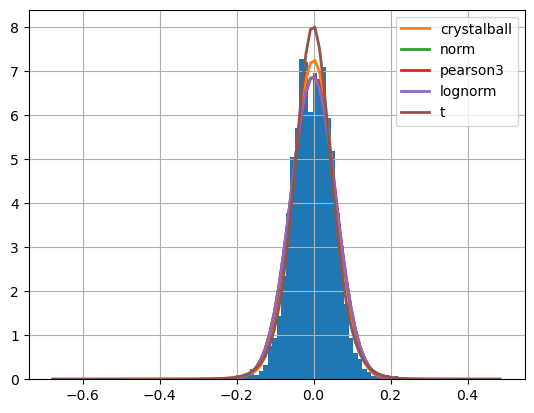

In [94]:
f = Fitter(y_train.values,distributions=['crystalball','expon','gamma','lognorm','norm','pearson3','triang','uniform','weibull_min','weibull_max',
                                         'logistic','t'])
f.fit()
f.summary()

In [26]:
cdes, y_grid_flexcode = model.predict(X_test.values, n_grid=1000)

In [27]:
# Function to calculate the conditional mean (expected value)
def conditional_mean(cde, y_grid):
    mean_est = np.round(np.sum(y_grid * cde) / np.sum(cde),4)  # Mean as the weighted average
    return mean_est

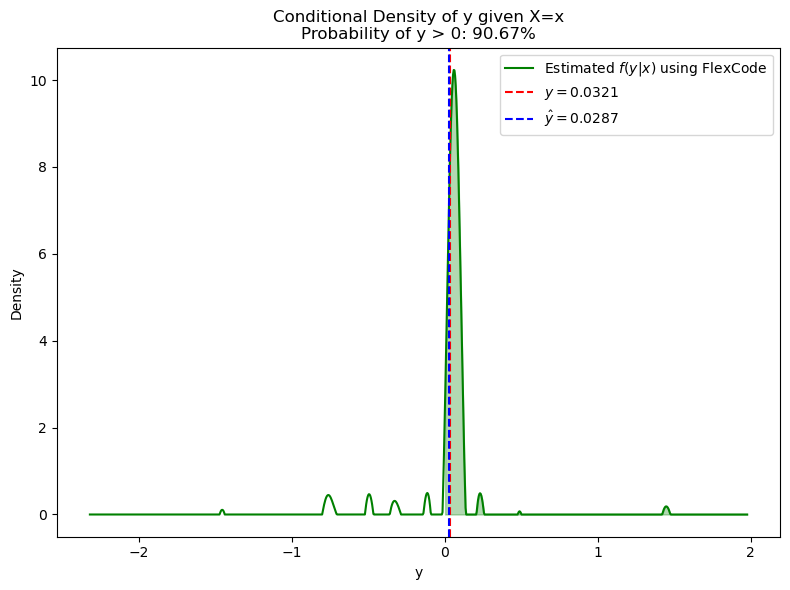

In [96]:
# Define the range for y values based on your data
y_grid_refined = np.linspace(y_test.min(), y_test.max(), 1000)
y_grid_flexcode = y_grid_flexcode.ravel()
# Plotting setup
fig, ax = plt.subplots(figsize=(8, 6))
beta, m = 1, 2

# Iterate over a few random samples for visualization
for c, sample_index in enumerate(np.random.RandomState().choice(len(X_test), size=1, replace=False)):
    y_value = np.round(y_test.values[sample_index], 4)
    
    # Calculate PDF of crystalball distribution for the given y_value
    pdf_logistic = stats.crystalball.pdf(y_grid_refined, loc=y_value, scale=0.02, beta=beta, m=m)
    cde = cdes[sample_index]
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    
    # Plot real conditional density (logistic distribution)
    # ax.plot(y_grid_refined, pdf_logistic, "--", color=f"blue", label=f"Real $f(y | x = {y_value})$ Logistic")
    
    # Plot estimated CDE using FlexCode model
    ax.plot(y_grid_flexcode, cde, color=f"green", label=f"Estimated $f(y | x)$ using FlexCode")
    
    # Shade the area where y > 0 for the FlexCode model CDE
    ax.fill_between(y_grid_flexcode, 0, cde, where=(y_grid_flexcode > 0), color=f"green", alpha=0.3)
    #ax.fill_between(y_grid_flexcode, 0, cde, where=(cde >= q1) & (cde <= q3), color="green", alpha=0.3, label=f"Q1-Q3 range {q1} - {q3} ")
    
    # Highlight the actual y value with a vertical line
    ax.axvline(y_value, color="red", linestyle="--", label=f"$y = {y_value}$")
    
    # Calculate conditional mean
    y_hat = round(float(np.sum(cde_df['cde'] * cde_df['y_grid_flexcode'])/np.sum(cde_df['cde'])),4)
    
    # Highlight the conditional mean y_hat with a vertical line
    ax.axvline(y_hat, color="blue", linestyle="--", label=rf"$\hat{{y}} = {y_hat}$")
    
    # Calculate positive probability
    positive_prob = np.round((cde_df[(cde_df['cde']>0)&(cde_df['y_grid_flexcode']>0)]['cde'].sum()/cde_df['cde'].sum())*100, 2)
# Set plot labels and title
ax.set_title("Conditional Density of y given X=x\n" + f"Probability of y > 0: {positive_prob}%")
ax.set_xlabel("y")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()

In [30]:
y_preds = []

for ix in range(len(cdes)):
    cde = cdes[ix]
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    y_preds.append(round(float(np.sum(cde_df['cde'] * cde_df['y_grid_flexcode'])/np.sum(cde_df['cde'])),4))

In [36]:
positive_probs = []
for i in range(cdes.shape[0]):
    cde = cdes[i]
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    positive_prob = np.round((cde_df[(cde_df['cde']>0)&(cde_df['y_grid_flexcode']>0)]['cde'].sum()/cde_df['cde'].sum())*100, 2)
    positive_probs.append(positive_prob)

In [44]:
to_df['to_team'] = df_analysis[(df_analysis['to']==1)&(df_analysis['to_non_run']==1)]['to_team'].values

In [45]:
to_df

,scoring_ratio,avg_2_scoring_ratio,avg_3_scoring_ratio,avg_4_scoring_ratio,avg_5_scoring_ratio,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,net_diff_home,net_diff_away,next_3_avg_scoring_ratio,previous_run_time,last_run_time,time_spent_run,to_time,Season,to_team
3,0.025105,0.123663,0.073895,0.060916,0.060916,1.000000,1.0,1.0,NaN,NaN,NaN,6.0,-6.0,-0.037643,542,303,239,439.0,15,DEN
13,0.016129,0.008065,0.005376,0.010611,0.010611,1.500000,2.0,1.0,1.000000,1.0,1.0,1.0,-1.0,-0.021485,580,518,62,544.0,15,DEN
19,0.096774,0.012673,0.018449,0.028122,0.011971,1.400000,2.0,1.0,1.750000,3.0,1.0,6.0,-6.0,-0.079101,279,217,62,216.0,15,DEN
22,-0.250000,-0.096429,-0.079101,-0.035132,-0.042391,1.833333,3.0,1.0,1.333333,2.0,1.0,-3.0,3.0,0.069473,137,125,12,124.0,15,LAC
26,0.011111,0.011111,0.011111,0.011111,0.011111,NaN,NaN,NaN,NaN,NaN,NaN,4.0,-4.0,-0.027987,720,360,360,411.0,15,DEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527895,-0.015556,-0.015556,-0.015556,-0.015556,-0.015556,NaN,NaN,NaN,NaN,NaN,NaN,-7.0,7.0,0.148766,720,270,450,334.0,23,PHI
527897,-0.074534,0.129400,0.081081,0.081081,0.081081,1.000000,1.0,1.0,5.000000,5.0,5.0,-12.0,12.0,0.081019,261,100,161,167.0,23,PHI
527919,-0.014085,0.010502,0.005139,-0.022932,-0.021520,1.333333,2.0,1.0,1.000000,1.0,1.0,-2.0,2.0,0.012821,484,342,142,396.0,23,PHI
527944,0.008889,0.008889,0.008889,0.008889,0.008889,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-2.0,0.014818,720,495,225,534.0,23,MEM


In [49]:
df_2023 = df_analysis[(df_analysis['Season']==23)&(df_analysis['to_non_run']==1)]

In [50]:
df_2023['to_team'] = df_2023['to_team'].str.lstrip()
df_2023['to_team'] = df_2023['to_team'].str.rstrip()

C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\3794954361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['to_team'] = df_2023['to_team'].str.lstrip()
C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\3794954361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['to_team'] = df_2023['to_team'].str.rstrip()


In [52]:
df_2023['positive_prob'] = positive_probs

C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\2042018945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['positive_prob'] = positive_probs


In [53]:
df_2023 = df_2023[df_2023['to_team'].isin(['FLA','NZB','MRA','CNS'])==False]

<Axes: xlabel='to_team'>

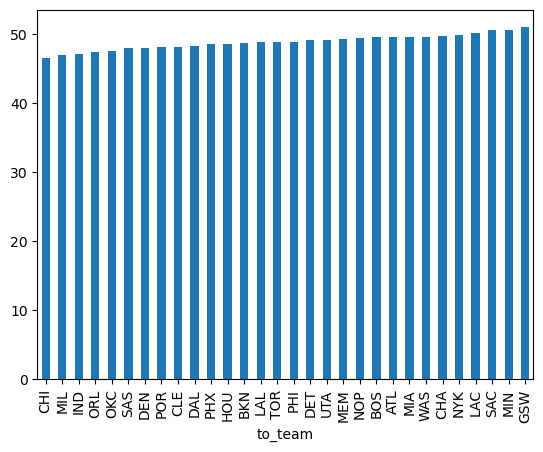

In [60]:
df_2023.groupby('to_team')['positive_prob'].mean().sort_values().plot(kind='bar')

In [64]:
df_2023

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time,net_diff_home,net_diff_away,scoring_ratio,Season,avg_2_scoring_ratio,avg_3_scoring_ratio,avg_4_scoring_ratio,avg_5_scoring_ratio,next_1_avg_scoring_ratio,next_2_avg_scoring_ratio,next_3_avg_scoring_ratio,next_4_avg_scoring_ratio,next_5_avg_scoring_ratio,run_length_continued,positive_prob
244035,6,00123000012,MIN,DAL,61.0,38.0,1,1,0,1,0,1,MIN,1,64.0,41.0,DAL,1,59.0,38.0,DAL,1.500000,2.0,1.0,2.0,2.0,2.0,DAL,1.0,240,229,11,228.0,2.0,-2.0,0.181818,23,0.085590,0.041908,0.035949,0.036335,0.000000,-0.027778,-0.000975,-0.020846,0.019687,0,27.24
244057,6,00123000021,DAL,MIN,8.0,10.0,1,1,1,0,0,1,MIN,1,10.0,10.0,DAL,1,8.0,8.0,DAL,1.000000,1.0,1.0,1.0,1.0,1.0,DAL,1.0,477,436,41,435.0,-2.0,2.0,-0.048780,23,0.042276,0.015526,0.014304,0.011443,0.095238,-0.002381,0.032895,0.010386,0.001697,0,69.87
244073,6,00123000022,DAL,MIN,22.0,38.0,4,1,1,0,1,0,MIN,1,24.0,40.0,MIN,2,20.0,31.0,DAL,1.000000,1.0,1.0,1.5,2.0,1.0,DAL,1.0,26,455,-429,514.0,-5.0,5.0,0.011655,23,0.029924,0.022437,-0.007366,-0.007686,0.000000,-0.022727,0.018182,0.016550,0.022879,2,42.43
244078,3,00123000023,DAL,MIN,50.0,67.0,1,1,1,0,0,1,MIN,3,53.0,67.0,DAL,6,50.0,65.0,MIN,2.000000,2.0,2.0,NaN,NaN,NaN,DAL,1.0,464,441,23,440.0,-2.0,2.0,-0.086957,23,-0.041525,-0.041525,-0.041525,-0.041525,0.061224,0.121521,0.081014,-0.189239,-0.177478,0,89.03
244099,9,00123000031,GSW,LAL,23.0,21.0,3,1,0,1,1,0,GSW,1,23.0,19.0,GSW,1,18.0,19.0,GSW,2.000000,3.0,1.0,2.0,2.0,2.0,LAL,1.0,280,157,123,173.0,3.0,-3.0,0.024390,23,0.312195,0.186625,0.127773,0.118435,-0.117647,-0.044225,-0.048531,-0.030301,0.095759,1,45.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527895,2,16223000051,PHI,OKC,9.0,16.0,8,1,1,0,6,0,OKC,1,9.0,13.0,PHI,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI,1.0,720,270,450,334.0,-7.0,7.0,-0.015556,23,-0.015556,-0.015556,-0.015556,-0.015556,0.333333,0.129400,0.148766,0.069908,0.100371,1,32.18
527897,4,16223000051,PHI,OKC,12.0,28.0,5,1,1,0,1,0,OKC,2,15.0,28.0,PHI,1,9.0,13.0,PHI,1.000000,1.0,1.0,5.0,5.0,5.0,PHI,1.0,261,100,161,167.0,-12.0,12.0,-0.074534,23,0.129400,0.081081,0.081081,0.081081,0.187500,0.010417,0.081019,0.042471,0.019070,3,74.43
527919,7,16223000053,PHI,OKC,46.0,69.0,3,1,1,0,1,0,OKC,2,48.0,71.0,PHI,2,44.0,65.0,PHI,1.333333,2.0,1.0,1.0,1.0,1.0,PHI,1.0,484,342,142,396.0,-2.0,2.0,-0.014085,23,0.010502,0.005139,-0.022932,-0.021520,0.000000,0.019231,0.012821,-0.052885,-0.025641,1,26.47
527944,2,16223000063,UTA,MEM,50.0,41.0,3,1,0,1,1,0,UTA,1,53.0,41.0,UTA,1,45.0,38.0,UTA,NaN,NaN,NaN,NaN,NaN,NaN,MEM,1.0,720,495,225,534.0,2.0,-2.0,0.008889,23,0.008889,0.008889,0.008889,0.008889,0.166667,0.030702,0.014818,-0.016664,-0.010734,1,62.30


In [97]:
df_analysis[(df_analysis['to_non_run']==1)]

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time,net_diff_home,net_diff_away,scoring_ratio,Season,avg_2_scoring_ratio,avg_3_scoring_ratio,avg_4_scoring_ratio,avg_5_scoring_ratio,next_1_avg_scoring_ratio,next_2_avg_scoring_ratio,next_3_avg_scoring_ratio,next_4_avg_scoring_ratio,next_5_avg_scoring_ratio,run_length_continued
3,5,00115000011,LAC,DEN,14.0,6.0,5,1,0,1,2,0,LAC,3,16.0,11.0,DEN,1,6.0,4.0,LAC,1.000000,1.0,1.0,NaN,NaN,NaN,DEN,1.0,542,303,239,439.0,6.0,-6.0,0.025105,15,0.123663,0.073895,0.060916,0.060916,-0.065217,-0.027053,-0.037643,-0.000455,-0.008131,2
13,5,00115000012,LAC,DEN,31.0,24.0,3,1,0,1,1,0,LAC,2,32.0,27.0,DEN,2,28.0,22.0,DEN,1.500000,2.0,1.0,1.000000,1.0,1.0,DEN,1.0,580,518,62,544.0,1.0,-1.0,0.016129,15,0.008065,0.005376,0.010611,0.010611,-0.068966,-0.060799,-0.021485,-0.008614,-0.021177,1
19,11,00115000012,LAC,DEN,46.0,35.0,3,1,0,1,2,1,LAC,1,46.0,37.0,DEN,2,40.0,35.0,DEN,1.400000,2.0,1.0,1.750000,3.0,1.0,DEN,1.0,279,217,62,216.0,6.0,-6.0,0.096774,15,0.012673,0.018449,0.028122,0.011971,-0.044444,0.006349,-0.079101,-0.035287,-0.035777,0
22,14,00115000012,LAC,DEN,48.0,40.0,1,1,1,0,0,1,DEN,2,53.0,40.0,LAC,1,48.0,37.0,LAC,1.833333,3.0,1.0,1.333333,2.0,1.0,LAC,1.0,137,125,12,124.0,-3.0,3.0,-0.250000,15,-0.096429,-0.079101,-0.035132,-0.042391,0.096154,0.029209,0.069473,-0.010396,0.003112,0
26,2,00115000013,LAC,DEN,68.0,50.0,3,1,0,1,0,0,LAC,1,70.0,50.0,LAC,1,56.0,42.0,LAC,NaN,NaN,NaN,NaN,NaN,NaN,DEN,1.0,720,360,360,411.0,4.0,-4.0,0.011111,15,0.011111,0.011111,0.011111,0.011111,0.035088,-0.065789,-0.027987,-0.035696,-0.028557,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527895,2,16223000051,PHI,OKC,9.0,16.0,8,1,1,0,6,0,OKC,1,9.0,13.0,PHI,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI,1.0,720,270,450,334.0,-7.0,7.0,-0.015556,23,-0.015556,-0.015556,-0.015556,-0.015556,0.333333,0.129400,0.148766,0.069908,0.100371,1
527897,4,16223000051,PHI,OKC,12.0,28.0,5,1,1,0,1,0,OKC,2,15.0,28.0,PHI,1,9.0,13.0,PHI,1.000000,1.0,1.0,5.000000,5.0,5.0,PHI,1.0,261,100,161,167.0,-12.0,12.0,-0.074534,23,0.129400,0.081081,0.081081,0.081081,0.187500,0.010417,0.081019,0.042471,0.019070,3
527919,7,16223000053,PHI,OKC,46.0,69.0,3,1,1,0,1,0,OKC,2,48.0,71.0,PHI,2,44.0,65.0,PHI,1.333333,2.0,1.0,1.000000,1.0,1.0,PHI,1.0,484,342,142,396.0,-2.0,2.0,-0.014085,23,0.010502,0.005139,-0.022932,-0.021520,0.000000,0.019231,0.012821,-0.052885,-0.025641,1
527944,2,16223000063,UTA,MEM,50.0,41.0,3,1,0,1,1,0,UTA,1,53.0,41.0,UTA,1,45.0,38.0,UTA,NaN,NaN,NaN,NaN,NaN,NaN,MEM,1.0,720,495,225,534.0,2.0,-2.0,0.008889,23,0.008889,0.008889,0.008889,0.008889,0.166667,0.030702,0.014818,-0.016664,-0.010734,1


In [103]:
coaches_df = pd.read_csv(r'C:\Users\isaac\Desktop\Proyectos\nba_analysis\timeout_analysis\preprocessing\data\regular_season_coaches.csv')

In [109]:
df_coaches = df_analysis[(df_analysis['to_non_run']==1)]

In [110]:
df_coaches['Season'] = df_coaches['gp'].str[3:5].astype(int)

C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\3470110751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['Season'] = df_coaches['gp'].str[3:5].astype(int)


In [114]:
coaches_df['Season'] = coaches_df['SEASON_YEAR'] - 2000

In [117]:
df_coaches['GAME_ID'] = df_coaches['gp'].str[:-1]

C:\Users\isaac\AppData\Local\Temp\ipykernel_25380\2880319372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['GAME_ID'] = df_coaches['gp'].str[:-1]


In [120]:
coaches_df['GAME_ID'] = coaches_df['GAME_ID'].astype(str)

In [132]:
df_coaches['GAME_ID'].astype(int)

3           11500001
13          11500001
19          11500001
22          11500001
26          11500001
             ...    
527895    1622300005
527897    1622300005
527919    1622300005
527944    1622300006
527952    1622300006
Name: GAME_ID, Length: 53356, dtype: int64

In [121]:
df_coaches.merge(coaches_df,left_on=['Season','GAME_ID','to_team'],right_on=['Season','GAME_ID','TEAM_ABBREVIATION'])

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time,net_diff_home,net_diff_away,scoring_ratio,Season,avg_2_scoring_ratio,avg_3_scoring_ratio,avg_4_scoring_ratio,avg_5_scoring_ratio,next_1_avg_scoring_ratio,next_2_avg_scoring_ratio,next_3_avg_scoring_ratio,next_4_avg_scoring_ratio,next_5_avg_scoring_ratio,run_length_continued,GAME_ID,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,SEASON_YEAR,Coach


In [122]:
coaches_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,SEASON_YEAR,Coach,Season
0,22015,1610612737,ATL,Atlanta Hawks,21500001,2015-10-27,ATL vs. DET,L,239,94,37,82,0.451,8,27.0,0.296,12,15,0.800,7.0,33.0,40.0,22,9.0,4,15,25,-12.0,2015,Mike Budenholzer,15
1,22015,1610612737,ATL,Atlanta Hawks,21500019,2015-10-29,ATL @ NYK,W,240,112,42,83,0.506,10,24.0,0.417,18,26,0.692,7.0,32.0,39.0,26,11.0,4,15,18,11.0,2015,Mike Budenholzer,15
2,22015,1610612737,ATL,Atlanta Hawks,21500026,2015-10-30,ATL vs. CHA,W,241,97,36,83,0.434,8,23.0,0.348,17,22,0.773,8.0,37.0,45.0,23,9.0,4,15,17,3.0,2015,Mike Budenholzer,15
3,22015,1610612737,ATL,Atlanta Hawks,21500039,2015-11-01,ATL @ CHA,W,240,94,37,88,0.420,7,29.0,0.241,13,14,0.929,9.0,39.0,48.0,22,9.0,6,11,16,2.0,2015,Mike Budenholzer,15
4,22015,1610612737,ATL,Atlanta Hawks,21500055,2015-11-03,ATL @ MIA,W,239,98,37,90,0.411,7,21.0,0.333,17,22,0.773,16.0,35.0,51.0,25,10.0,1,15,14,6.0,2015,Mike Budenholzer,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21493,22023,1610612764,WAS,Washington Wizards,22301117,2024-04-05,WAS vs. POR,L,241,102,38,88,0.432,5,33.0,0.152,21,30,0.700,12.0,33.0,45.0,24,9.0,5,9,21,-6.0,2023,Wes Unseld,23
21494,22023,1610612764,WAS,Washington Wizards,22301137,2024-04-07,WAS @ TOR,L,239,122,42,89,0.472,16,40.0,0.400,22,30,0.733,8.0,35.0,43.0,29,9.0,11,15,25,-8.0,2023,Wes Unseld,23
21495,22023,1610612764,WAS,Washington Wizards,22301152,2024-04-09,WAS @ MIN,L,240,121,44,89,0.494,20,43.0,0.465,13,17,0.765,7.0,34.0,41.0,26,5.0,4,13,22,-9.0,2023,Wes Unseld,23
21496,22023,1610612764,WAS,Washington Wizards,22301172,2024-04-12,WAS vs. CHI,L,241,127,45,86,0.523,18,43.0,0.419,19,29,0.655,4.0,35.0,39.0,32,6.0,5,12,22,-2.0,2023,Wes Unseld,23


In [144]:
summary = pd.read_pickle(r'C:\Users\isaac\Desktop\Proyectos\nba_analysis\timeout_analysis\preprocessing\data\possession_summary_2019-2023.pkl')

In [145]:
summary

,GAME_ID,PERIOD,HomeName,AwayName,possession_id,possession,start,end,end_home_score,end_away_score,home_timeout_after,away_timeout_after,last_event,score,last_score,home_poss,offense,defense,gp
1,0011900001,1,HOU,SDS,1,HOU,25,25,36.0,14.0,False,False,Hartenstein Free Throw 2 of 2 (5 PTS),True,NaN,True,HOU,SDS,00119000011
7,0011900001,1,HOU,SDS,154,HOU,694,694,1.0,0.0,False,False,Harden Free Throw 1 of 3 (1 PTS),True,HOU,True,HOU,SDS,00119000011
8,0011900001,1,HOU,SDS,155,HOU,694,694,2.0,0.0,False,False,Harden Free Throw 2 of 3 (2 PTS),True,HOU,True,HOU,SDS,00119000011
9,0011900001,1,HOU,SDS,156,HOU,694,694,3.0,0.0,False,False,Harden Free Throw 3 of 3 (3 PTS),True,HOU,True,HOU,SDS,00119000011
13,0011900001,1,HOU,SDS,160,SDS,658,658,3.0,2.0,False,False,Mingxin 1' Layup (2 PTS) (Motiejunas 1 AST),True,HOU,False,SDS,HOU,00119000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885921,1622300006,4,UTA,MEM,153,UTA,99,103,94.0,76.0,False,False,Agbaji 5' Alley Oop Dunk (22 PTS) (George 5 AST),False,MEM,True,UTA,MEM,16223000064
1885922,1622300006,4,UTA,MEM,154,UTA,62,62,96.0,78.0,False,False,Ross 12' Floating Jump Shot (5 PTS),True,MEM,True,UTA,MEM,16223000064
1885923,1622300006,4,UTA,MEM,155,MEM,61,61,96.0,79.0,False,False,Allen Free Throw 1 of 2 (7 PTS),True,UTA,False,MEM,UTA,16223000064
1885925,1622300006,4,UTA,MEM,157,UTA,50,59,98.0,79.0,False,False,Juzang 4' Driving Layup (15 PTS),True,MEM,True,UTA,MEM,16223000064
